<a href="https://colab.research.google.com/github/skbetz54/Samuel_DATA606/blob/main/Notebooks/Machine_Learning_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning Implementation**

Now that our data from huggingface has been cleaned and preprocessed [here](https://colab.research.google.com/drive/1Zf6250GENm1EVOdGW35kDIj8AaDKQcbz?authuser=1#scrollTo=yf5hmBqViYX1&uniqifier=1), we can now begin to work on our sentiment classifier, which will in turn be used to predict the level of fear being used in real-world news articles.

In [1]:
"""
The below code is pulling publicly available code from UMBC adjunct professor Edward Raff. 
These notebooks include functions that aid in the training and testing of various deep learning models,
some of which I will be using within this code (with brief explanations of the functions as they appear).

"""

!git clone https://github.com/EdwardRaff/Inside-Deep-Learning.git
%run /content/Inside-Deep-Learning/idlmam.py

Cloning into 'Inside-Deep-Learning'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 34 (delta 10), reused 28 (delta 7), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [16]:
# Necessary Notebook Imports

from google.colab import files, drive

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader

import time
import tqdm
from itertools import islice

In [3]:
# Mounting my google drive to upload the necessary csv file from part

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Data Loading**

In [4]:
save_path = "/content/gdrive/MyDrive/DATA606/Data/output_cleaned.csv"
save_path_50 = "/content/gdrive/MyDrive/DATA606/Data/output_cleaned_50k.csv"
save_path_15 = "/content/gdrive/MyDrive/DATA606/Data/output_cleaned_15k.csv"


df = pd.read_csv(save_path)
df_50 = pd.read_csv(save_path_50)
df_15 = pd.read_csv(save_path_15)

df.drop(columns='Unnamed: 0', inplace=True)
df_50.drop(columns='Unnamed: 0', inplace=True)
df_15.drop(columns='Unnamed: 0', inplace=True)

In [9]:
# Dictionary Creation
"""
-----------------------
A dictionary is one of the most important things to have for training and testing a Recurrent
Neural Network. This cell is to create a dictionary for each dataset, pairing the emotion 
(fear, anger, sadness, joy, love, or surprise) and their associated tweets. 
-----------------------
"""
# Full Dataset

t1 = time.perf_counter()

tweet_dict = {key: value["lemma_string"].tolist() for key, value in df.groupby("emotions")}

t2 = time.perf_counter()

print("Time to create tweet dictionary: "+ str(t2-t1) +" seconds")
print("Dictionary length (number of unique emotions): " + str(len(tweet_dict)))
print("Number of items per emotion:")
for key, value in tweet_dict.items():
  print(key, len([item for item in value if item]))


# 50K Downsampled Dataset

t1 = time.perf_counter()

tweet_dict_50 = {key: value["lemma_string"].tolist() for key, value in df_50.groupby("emotions")}

t2 = time.perf_counter()

print("\nTime to create tweet dictionary: "+ str(t2-t1) +" seconds")
print("Dictionary length (number of unique emotions): " + str(len(tweet_dict_50)))
print("Number of items per emotion:")
for key, value in tweet_dict_50.items():
  print(key, len([item for item in value if item]))


# 15K Downsampled Dataset

t1 = time.perf_counter()

tweet_dict_15 = {key: value["lemma_string"].tolist() for key, value in df_15.groupby("emotions")}

t2 = time.perf_counter()

print("\nTime to create tweet dictionary: "+ str(t2-t1) +" seconds")
print("Dictionary length (number of unique emotions): " + str(len(tweet_dict_15)))
print("Number of items per emotion:")
for key, value in tweet_dict_15.items():
  print(key, len([item for item in value if item]))


Time to create tweet dictionary: 0.33870168299995385 seconds
Dictionary length (number of unique emotions): 6
Number of items per emotion:
anger 57317
fear 47712
joy 141067
love 34554
sadness 121187
surprise 14972

Time to create tweet dictionary: 0.19717584900013208 seconds
Dictionary length (number of unique emotions): 6
Number of items per emotion:
anger 57317
fear 47712
joy 50000
love 34554
sadness 50000
surprise 14972

Time to create tweet dictionary: 0.06744759200000772 seconds
Dictionary length (number of unique emotions): 6
Number of items per emotion:
anger 15000
fear 15000
joy 15000
love 15000
sadness 15000
surprise 14972


In [10]:
# Vocabulary Creation
"""
-----------------------
Creating a vocabulary is also an important step in using text data for machine learning.
In this cell, each unique word in the dataset is mapped to an index (and vice versa) 
so the dataset created in the next step can map the words to an integer value 
(since text data cannot be utilized in Pytorch models).

Note: the 3 words that start each dataset's dictionary are "PAD", "SOS", and "EOS", 
which represent values for padding, the start of a sentence, and the end of a sentence.
These are all necessary because for models with a batch size greater than 1, we need to 
pad each tweet/sentence so each input value is the same.
-----------------------
"""

combined = df.lemma_string.str.cat(sep = " ")

t1 = time.perf_counter()

idx2word = {0:'PAD',1:'SOS',2:'EOS'}

for word in combined.split():
  if word not in idx2word.values():
    idx2word[len(idx2word)] = word

t2 = time.perf_counter()

print("Time to create vocabulary: %f seconds" %(t2-t1))
print("Length of Vocabulary: %d" %(len(idx2word)))

#50K Dataset

combined_50 = df_50.lemma_string.str.cat(sep = " ")

t1 = time.perf_counter()

idx2word_50 = {0:'PAD',1:'SOS',2:'EOS'}

for word in combined_50.split():
  if word not in idx2word_50.values():
    idx2word_50[len(idx2word_50)] = word

t2 = time.perf_counter()

print("\nTime to create vocabulary: %f seconds" %(t2-t1))
print("Length of Vocabulary: %d" %(len(idx2word_50)))

#15K Dataset

combined_15 = df_15.lemma_string.str.cat(sep = " ")

t1 = time.perf_counter()

idx2word_15 = {0:'PAD',1:'SOS',2:'EOS'}

for word in combined_15.split():
  if word not in idx2word_15.values():
    idx2word_15[len(idx2word_15)] = word

t2 = time.perf_counter()

print("\nTime to create vocabulary: %f seconds" %(t2-t1))
print("Length of Vocabulary: %d" %(len(idx2word_15)))


# Creating the inverse of the above dictionaries for the purpose of output formatting

word2idx = {v: k for k, v in idx2word.items()}
word2idx_50 = {v: k for k, v in idx2word_50.items()}
word2idx_15 = {v: k for k, v in idx2word_15.items()}

Time to create vocabulary: 304.680077 seconds
Length of Vocabulary: 65883

Time to create vocabulary: 150.564071 seconds
Length of Vocabulary: 50877

Time to create vocabulary: 43.383180 seconds
Length of Vocabulary: 30000


In [11]:
# Emotion Dataset

"""
-----------------------
Now that we have both a dictionary of tweets and a vocabulary of all words used in the dataset,
we can create a custom Pytorch Dataset object, which helps in loading, locating, and transforming
the input data.
-----------------------
"""


class EmotionDataset(Dataset):
  
  def __init__(self, dictionary, vocabulary):
    self.label_names = [name for name in dictionary.keys()]
    self.data = []
    self.labels = []
    self.vocabulary = vocabulary
    self.dictionary = dictionary
    self.max = 0

    """
    Iterate through the dataset's dictionary and extract both the tweet and its corresponding label.
    """

    for idx, emotion in enumerate(self.label_names):
      for sentence in dictionary[emotion]:
        self.data.append(sentence)
        self.labels.append(idx)

  def __len__(self):
    return len(self.data)
    """
    return the length of the datset.
    """


  def list2InputVec(self, input_list):
    """
    This method is going to take an input list (a.k.a the individual words within the sentence)
    and return a pytorch vector of long integers, where each integer represents the index within the assigned
    vocabulary. 
    """

    T = len(str(input_list).split(sep = " "))

    sentence_vect = torch.zeros((T), dtype=torch.long) 

    for position, vector in enumerate(str(input_list).split(sep=" ")):
      sentence_vect[position] = word2idx[vector]

    return sentence_vect

  def __getitem__(self, index):
    name = self.data[index]
    label = self.labels[index]
    
    label_vector = torch.tensor([label], dtype = torch.long)                                

    return self.list2InputVec(name), label

In [15]:
emo_dataset = EmotionDataset(dictionary=tweet_dict, vocabulary = idx2word)
emo_dataset_50 = EmotionDataset(dictionary=tweet_dict_50, vocabulary = idx2word_50)
emo_dataset_15 = EmotionDataset(dictionary=tweet_dict_15, vocabulary = idx2word_15)

print("Length of Full Dataset: %d" %(len(emo_dataset)))
print("Length of Downsampled Dataset: %d" %(len(emo_dataset_50)))
print("Length of Curated Dataset - 15k Samples: %d" %(len(emo_dataset_15)))

Length of Full Dataset: 416809
Length of Downsampled Dataset: 254555
Length of Curated Dataset - 15k Samples: 89972


In [17]:
"""
Creating train and test splits for each of the above datasets which are stratified to keep the same
label stratification throughout the splits
"""

# Creating random index values for each dataset to take when making training and test datasets

train_idx, test_idx = train_test_split(list(range(len(emo_dataset.labels))), test_size = .2, stratify = emo_dataset.labels)
train_idx_50, test_idx_50 = train_test_split(list(range(len(emo_dataset_50.labels))), test_size = .2, stratify = emo_dataset_50.labels)
train_idx_15, test_idx_15 = train_test_split(list(range(len(emo_dataset_15.labels))), test_size = .2, stratify = emo_dataset_15.labels)

# Using the above indexes to create the datasets

train_data = torch.utils.data.Subset(emo_dataset, train_idx)
test_data = torch.utils.data.Subset(emo_dataset, test_idx)

train_data_50 = torch.utils.data.Subset(emo_dataset_50, train_idx_50)
test_data_50 = torch.utils.data.Subset(emo_dataset_50, test_idx_50)

train_data_15 = torch.utils.data.Subset(emo_dataset_15, train_idx_15)
test_data_15 = torch.utils.data.Subset(emo_dataset_15, test_idx_15)

In [30]:
# Creating Pytorch DataLoaders - Pad and Pack

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, collate_fn=pad_and_pack)

train_loader_50 = DataLoader(train_data_50, batch_size=16, shuffle=True, collate_fn=pad_and_pack)
test_loader_50 = DataLoader(test_data_50, batch_size=16, shuffle=False, collate_fn=pad_and_pack)

train_loader_15 = DataLoader(train_data_15, batch_size=16, shuffle=True, collate_fn=pad_and_pack)
test_loader_15 = DataLoader(test_data_15, batch_size=16, shuffle=False, collate_fn=pad_and_pack)

# **RNN Training and Testing**

## **Batch Size = 16**

### **Full Dataset - Batch Size = 16**

In [31]:
D = 64 
vocab_size = len(word2idx)
hidden_nodes = 256 # Number of hidden nodes within the rnn layer
classes = len(tweet_dict.keys())

lossfunc = nn.CrossEntropyLoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [32]:
RNN_standard = nn.Sequential(
    nn.Embedding(vocab_size, D),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)


RNN_packed = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

RNN_packed.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(65883, 64)
  )
  (1): RNN(64, 256, batch_first=True)
  (2): LastTimeStep()
  (3): Linear(in_features=256, out_features=6, bias=True)
)

In [43]:
full_batch16_packed = train_simple_network(RNN_packed, lossfunc, train_loader,
test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=10)

### **50K Downsampled Dataset - Batch Size = 16**

In [34]:
RNN_packed = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

RNN_packed.to(device)

D = 64
vocab_size = len(word2idx)
hidden_nodes = 256
classes = len(tweet_dict.keys())

lossfunc = nn.CrossEntropyLoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [37]:
batch16_packed_50k = train_simple_network(RNN_packed, lossfunc, train_loader_50, test_loader=test_loader_50, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/12728 [00:00<?, ?it/s]

Testing:   0%|          | 0/3182 [00:00<?, ?it/s]

Training:   0%|          | 0/12728 [00:00<?, ?it/s]

Testing:   0%|          | 0/3182 [00:00<?, ?it/s]

Training:   0%|          | 0/12728 [00:00<?, ?it/s]

Testing:   0%|          | 0/3182 [00:00<?, ?it/s]

Training:   0%|          | 0/12728 [00:00<?, ?it/s]

Testing:   0%|          | 0/3182 [00:00<?, ?it/s]

Training:   0%|          | 0/12728 [00:00<?, ?it/s]

Testing:   0%|          | 0/3182 [00:00<?, ?it/s]

Training:   0%|          | 0/12728 [00:00<?, ?it/s]

Testing:   0%|          | 0/3182 [00:00<?, ?it/s]

Training:   0%|          | 0/12728 [00:00<?, ?it/s]

Testing:   0%|          | 0/3182 [00:00<?, ?it/s]

Training:   0%|          | 0/12728 [00:00<?, ?it/s]

Testing:   0%|          | 0/3182 [00:00<?, ?it/s]

Training:   0%|          | 0/12728 [00:00<?, ?it/s]

Testing:   0%|          | 0/3182 [00:00<?, ?it/s]

Training:   0%|          | 0/12728 [00:00<?, ?it/s]

Testing:   0%|          | 0/3182 [00:00<?, ?it/s]

### **15K Downsampled Dataset - Batch Size = 16**

In [38]:
RNN_packed = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

RNN_packed.to(device)

D = 64
vocab_size = len(word2idx)
hidden_nodes = 256
classes = len(tweet_dict.keys())

lossfunc = nn.CrossEntropyLoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [39]:
batch16_packed_15k = train_simple_network(RNN_packed, lossfunc, train_loader_15,
test_loader=test_loader_15, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

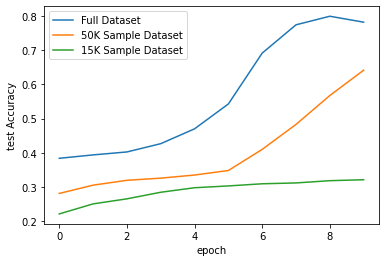

In [40]:
# Plotting differences in Test Accuracy

sns.lineplot(x='epoch', y='test Accuracy', data=full_batch16_packed, label='Full Dataset')
sns.lineplot(x='epoch', y='test Accuracy', data=batch16_packed_50k, label='50K Sample Dataset')
sns.lineplot(x='epoch', y='test Accuracy', data=batch16_packed_15k, label='15K Sample Dataset')

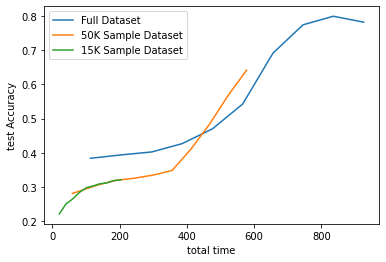

In [41]:
sns.lineplot(x='total time', y='test Accuracy', data=full_batch16_packed, label='Full Dataset')
sns.lineplot(x='total time', y='test Accuracy', data=batch16_packed_50k, label='50K Sample Dataset')
sns.lineplot(x='total time', y='test Accuracy', data=batch16_packed_15k, label='15K Sample Dataset')

## **Batch Size = 32**

### **Full Dataset - Batch Size = 32**

In [42]:
# Creating Pytorch DataLoaders - Pad and Pack

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=pad_and_pack)

train_loader_50 = DataLoader(train_data_50, batch_size=32, shuffle=True, collate_fn=pad_and_pack)
test_loader_50 = DataLoader(test_data_50, batch_size=32, shuffle=False, collate_fn=pad_and_pack)

train_loader_15 = DataLoader(train_data_15, batch_size=32, shuffle=True, collate_fn=pad_and_pack)
test_loader_15 = DataLoader(test_data_15, batch_size=32, shuffle=False, collate_fn=pad_and_pack)

In [45]:
RNN_packed = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

RNN_packed.to(device)

D = 64
vocab_size = len(word2idx)
hidden_nodes = 256
classes = len(tweet_dict.keys())

lossfunc = nn.CrossEntropyLoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [46]:
full_batch32_packed = train_simple_network(RNN_packed, lossfunc, train_loader,
test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/10421 [00:00<?, ?it/s]

Testing:   0%|          | 0/2606 [00:00<?, ?it/s]

Training:   0%|          | 0/10421 [00:00<?, ?it/s]

Testing:   0%|          | 0/2606 [00:00<?, ?it/s]

Training:   0%|          | 0/10421 [00:00<?, ?it/s]

Testing:   0%|          | 0/2606 [00:00<?, ?it/s]

Training:   0%|          | 0/10421 [00:00<?, ?it/s]

Testing:   0%|          | 0/2606 [00:00<?, ?it/s]

Training:   0%|          | 0/10421 [00:00<?, ?it/s]

Testing:   0%|          | 0/2606 [00:00<?, ?it/s]

Training:   0%|          | 0/10421 [00:00<?, ?it/s]

Testing:   0%|          | 0/2606 [00:00<?, ?it/s]

Training:   0%|          | 0/10421 [00:00<?, ?it/s]

Testing:   0%|          | 0/2606 [00:00<?, ?it/s]

Training:   0%|          | 0/10421 [00:00<?, ?it/s]

Testing:   0%|          | 0/2606 [00:00<?, ?it/s]

Training:   0%|          | 0/10421 [00:00<?, ?it/s]

Testing:   0%|          | 0/2606 [00:00<?, ?it/s]

Training:   0%|          | 0/10421 [00:00<?, ?it/s]

Testing:   0%|          | 0/2606 [00:00<?, ?it/s]

### **50K Downsampled Dataset - Batch Size = 32**

In [48]:
batch32_packed_50k = train_simple_network(RNN_packed, lossfunc, train_loader_50,
test_loader=test_loader_50, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/6364 [00:00<?, ?it/s]

Testing:   0%|          | 0/1591 [00:00<?, ?it/s]

Training:   0%|          | 0/6364 [00:00<?, ?it/s]

Testing:   0%|          | 0/1591 [00:00<?, ?it/s]

Training:   0%|          | 0/6364 [00:00<?, ?it/s]

Testing:   0%|          | 0/1591 [00:00<?, ?it/s]

Training:   0%|          | 0/6364 [00:00<?, ?it/s]

Testing:   0%|          | 0/1591 [00:00<?, ?it/s]

Training:   0%|          | 0/6364 [00:00<?, ?it/s]

Testing:   0%|          | 0/1591 [00:00<?, ?it/s]

Training:   0%|          | 0/6364 [00:00<?, ?it/s]

Testing:   0%|          | 0/1591 [00:00<?, ?it/s]

Training:   0%|          | 0/6364 [00:00<?, ?it/s]

Testing:   0%|          | 0/1591 [00:00<?, ?it/s]

Training:   0%|          | 0/6364 [00:00<?, ?it/s]

Testing:   0%|          | 0/1591 [00:00<?, ?it/s]

Training:   0%|          | 0/6364 [00:00<?, ?it/s]

Testing:   0%|          | 0/1591 [00:00<?, ?it/s]

Training:   0%|          | 0/6364 [00:00<?, ?it/s]

Testing:   0%|          | 0/1591 [00:00<?, ?it/s]

### **15K Downsampled Dataset - Batch Size = 32**

In [49]:
batch32_packed_50k = train_simple_network(RNN_packed, lossfunc, train_loader_15,
test_loader=test_loader_15, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Testing:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Testing:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Testing:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Testing:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Testing:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Testing:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Testing:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Testing:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Testing:   0%|          | 0/563 [00:00<?, ?it/s]

Training:   0%|          | 0/2250 [00:00<?, ?it/s]

Testing:   0%|          | 0/563 [00:00<?, ?it/s]

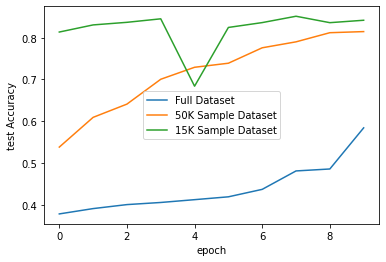

In [50]:
# Plotting differences in Test Accuracy

sns.lineplot(x='epoch', y='test Accuracy', data=full_batch32_packed, label='Full Dataset')
sns.lineplot(x='epoch', y='test Accuracy', data=batch32_packed_50k, label='50K Sample Dataset')
sns.lineplot(x='epoch', y='test Accuracy', data=batch32_packed_15k, label='15K Sample Dataset')

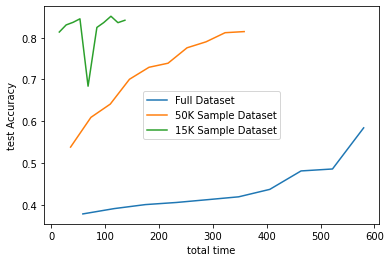

In [51]:
# Plotting differences in Time to achieve accuracy

sns.lineplot(x='total time', y='test Accuracy', data=full_batch32_packed, label='Full Dataset')
sns.lineplot(x='total time', y='test Accuracy', data=batch32_packed_50k, label='50K Sample Dataset')
sns.lineplot(x='total time', y='test Accuracy', data=batch32_packed_15k, label='15K Sample Dataset')

## **Batch Size = 1**

In [52]:
# Creating Pytorch DataLoaders - Pad and Pack

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

train_loader_50 = DataLoader(train_data_50, batch_size=1, shuffle=True)
test_loader_50 = DataLoader(test_data_50, batch_size=1, shuffle=False)

train_loader_15 = DataLoader(train_data_15, batch_size=1, shuffle=True)
test_loader_15 = DataLoader(test_data_15, batch_size=1, shuffle=False)

### **Full Dataset - Batch Size = 1**

In [53]:
D = 64
vocab_size = len(word2idx)
hidden_nodes = 256
classes = len(tweet_dict.keys())

lossfunc = nn.CrossEntropyLoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


RNN_standard = nn.Sequential(
    nn.Embedding(vocab_size, D),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

In [55]:
batch1_packed_full = train_simple_network(RNN_standard, lossfunc, train_loader,
test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=5)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/333447 [00:00<?, ?it/s]

Testing:   0%|          | 0/83362 [00:00<?, ?it/s]

Training:   0%|          | 0/333447 [00:00<?, ?it/s]

Testing:   0%|          | 0/83362 [00:00<?, ?it/s]

Training:   0%|          | 0/333447 [00:00<?, ?it/s]

Testing:   0%|          | 0/83362 [00:00<?, ?it/s]

Training:   0%|          | 0/333447 [00:00<?, ?it/s]

Testing:   0%|          | 0/83362 [00:00<?, ?it/s]

Training:   0%|          | 0/333447 [00:00<?, ?it/s]

Testing:   0%|          | 0/83362 [00:00<?, ?it/s]

### **50K Downsampled Dataset - Batch Size = 1**

In [56]:
D = 64
vocab_size = len(word2idx)
hidden_nodes = 256
classes = len(tweet_dict.keys())

lossfunc = nn.CrossEntropyLoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


RNN_standard = nn.Sequential(
    nn.Embedding(vocab_size, D),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

In [59]:
batch1_packed_50k = train_simple_network(RNN_standard, lossfunc, train_loader_50,
test_loader=test_loader_50, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=5)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/203644 [00:00<?, ?it/s]

Testing:   0%|          | 0/50911 [00:00<?, ?it/s]

Training:   0%|          | 0/203644 [00:00<?, ?it/s]

Testing:   0%|          | 0/50911 [00:00<?, ?it/s]

Training:   0%|          | 0/203644 [00:00<?, ?it/s]

Testing:   0%|          | 0/50911 [00:00<?, ?it/s]

Training:   0%|          | 0/203644 [00:00<?, ?it/s]

Testing:   0%|          | 0/50911 [00:00<?, ?it/s]

Training:   0%|          | 0/203644 [00:00<?, ?it/s]

Testing:   0%|          | 0/50911 [00:00<?, ?it/s]

### **15K Downsampled Dataset - Batch Size = 1**

In [60]:
D = 64
vocab_size = len(word2idx)
hidden_nodes = 256
classes = len(tweet_dict.keys())

lossfunc = nn.CrossEntropyLoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


RNN_standard = nn.Sequential(
    nn.Embedding(vocab_size, D),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

In [61]:
batch1_packed_15k = train_simple_network(RNN_standard, lossfunc, train_loader_15,
test_loader=test_loader_15, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

Training:   0%|          | 0/71977 [00:00<?, ?it/s]

Testing:   0%|          | 0/17995 [00:00<?, ?it/s]

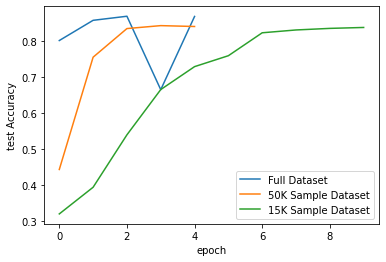

In [62]:
# Plotting differences in Test Accuracy

sns.lineplot(x='epoch', y='test Accuracy', data=batch1_packed_full, label='Full Dataset')
sns.lineplot(x='epoch', y='test Accuracy', data=batch1_packed_50k, label='50K Sample Dataset')
sns.lineplot(x='epoch', y='test Accuracy', data=batch1_packed_15k, label='15K Sample Dataset')

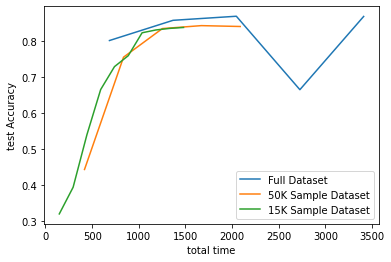

In [73]:
sns.lineplot(x='total time', y='test Accuracy', data=batch1_packed_full, label='Full Dataset')
sns.lineplot(x='total time', y='test Accuracy', data=batch1_packed_50k, label='50K Sample Dataset')
sns.lineplot(x='total time', y='test Accuracy', data=batch1_packed_15k, label='15K Sample Dataset')

## **Final Model - 15K**

In [69]:
# Creating Pytorch DataLoaders - Pad and Pack

train_loader_15 = DataLoader(train_data_15, batch_size=16, shuffle=True, collate_fn=pad_and_pack)
test_loader_15 = DataLoader(test_data_15, batch_size=16, shuffle=False, collate_fn=pad_and_pack)

In [70]:
RNN_packed = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size, D)),
    nn.RNN(D, hidden_nodes, batch_first = True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, classes)
)

RNN_packed.to(device)

D = 64
vocab_size = len(word2idx)
hidden_nodes = 256
classes = len(tweet_dict.keys())

lossfunc = nn.CrossEntropyLoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [71]:
batch16_packed_15k_final = train_simple_network(RNN_packed, lossfunc, train_loader_15,
test_loader=test_loader_15, score_funcs={'Accuracy': accuracy_score}, device=device,
epochs=25)

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

Training:   0%|          | 0/4499 [00:00<?, ?it/s]

Testing:   0%|          | 0/1125 [00:00<?, ?it/s]

## **Saving Best Model to Load Later**

In [ ]:
batch_one_train['name'] = 'Standard RNN 1 Batch - 15k'
batch_one_train['num_samples'] = '15k'
batch_packed_train['name'] = 'Standard RNN Packed Batch - 15k'
batch_packed_train['num_samples'] = '15k'

## **Model Saving**

The last thing we need to do is save the best model created in order to use it to predict real-world news articles.

In [ ]:
torch.save({
            'model_state_dict': .state_dict(),
            }, r"/content/gdrive/My Drive/DATA606/Models//model_best.pt")